In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

### Load data

In [2]:
def get_df():
    df = []
    for fname in glob.glob("csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
        report_date = fname.split("/")[-1].replace(".csv", "")
        _df = pd.read_csv(fname)
        _df["report_date"] = report_date
        df.append(_df)
    df = pd.concat(df)
    df["Last Update"] = pd.to_datetime(df["Last Update"])
    df["report_date"] = pd.to_datetime(df["report_date"])
    df["date"] = df["report_date"] # seems to make more sense than the "Last Update"
    df = df.sort_values(by="date")
    df = df.drop_duplicates()
    return df

In [3]:
df = get_df()
df = df[df["Country/Region"] == "Germany"]
#df = df[df["Country/Region"].apply(lambda x : "Korea" in x)]
#df = df[df["Country/Region"].apply(lambda x : "China" in x)]
#df = df[df["Country/Region"] == "Italy"]
#df = df[df["Country/Region"] == "Japan"]
#df = df[df["Country/Region"] == "Belgium"]
#df = df[df["Country/Region"] == "Iran"]
#df = df[df["Country/Region"] == "Spain"]
#df = df[df["Country/Region"] == "France"]

# uncomment if using multiple regions/countries
#df = df.groupby("date").sum()
#df = df.reset_index()

for field in ["Confirmed", "Deaths", "Recovered"]:
    df[f"{field}_diff"] = df[field].diff()
    df[f"{field}_diff_diff"] = df[f"{field}_diff"].diff()


#df = df.iloc[:-2]

In [4]:
df.drop(
    columns=[col for col in ["Province/State", "report_date", "Latitude", "Longitude"] if col in df]
).tail()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,date,Confirmed_diff,Confirmed_diff_diff,Deaths_diff,Deaths_diff_diff,Recovered_diff,Recovered_diff_diff
4,Germany,2020-03-17 18:53:02,9257.0,24.0,67.0,2020-03-17,1985.0,508.0,7.0,1.0,0.0,-21.0
4,Germany,2020-03-18 19:33:02,12327.0,28.0,105.0,2020-03-18,3070.0,1085.0,4.0,-3.0,38.0,38.0
4,Germany,2020-03-19 20:13:08,15320.0,44.0,113.0,2020-03-19,2993.0,-77.0,16.0,12.0,8.0,-30.0
3,Germany,2020-03-20 20:13:15,19848.0,67.0,180.0,2020-03-20,4528.0,1535.0,23.0,7.0,67.0,59.0
3,Germany,2020-03-21 20:43:02,22213.0,84.0,233.0,2020-03-21,2365.0,-2163.0,17.0,-6.0,53.0,-14.0


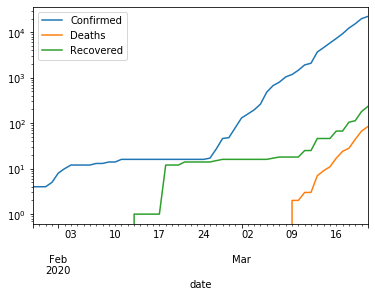

In [5]:
fig, ax = plt.subplots()
df.plot(x="date", y="Confirmed", ax=ax)
df.plot(x="date", y="Deaths", ax=ax)
df.plot(x="date", y="Recovered", ax=ax)
ax.set_yscale("log")

In [6]:
#df.plot.bar(x="date", y=["Confirmed_diff", "Deaths_diff", "Recovered_diff"], subplots=True)

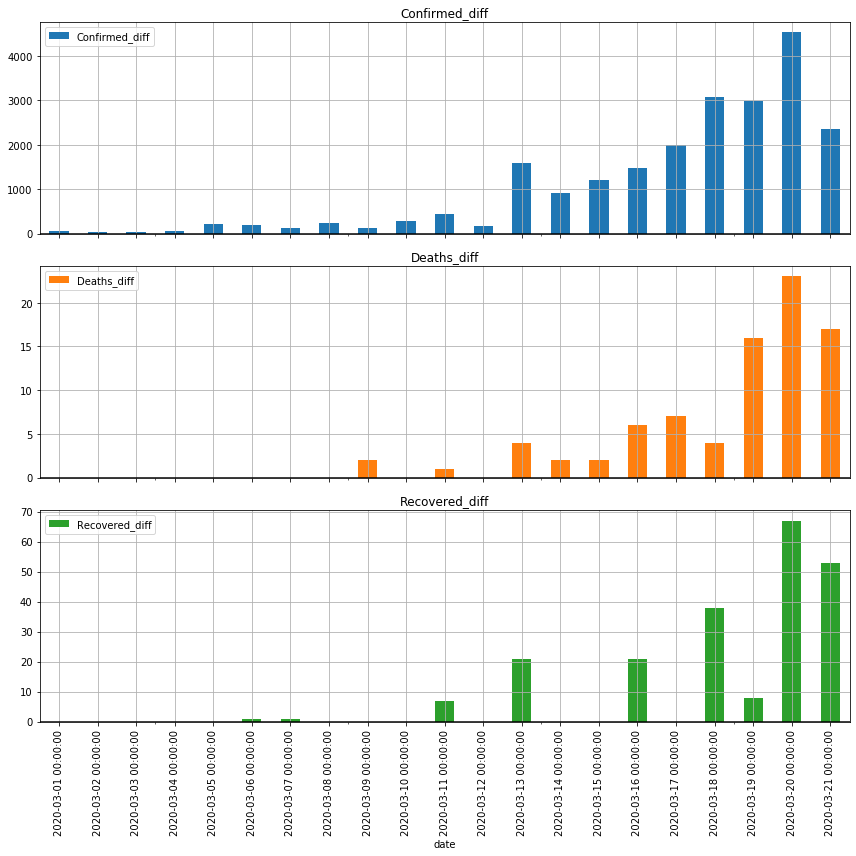

In [7]:
axs = df.iloc[-21:].plot.bar(
    x="date",
    #y=["Confirmed_diff_diff", "Deaths_diff_diff", "Recovered_diff_diff"],
    y=["Confirmed_diff", "Deaths_diff", "Recovered_diff"],
    subplots=True,
    figsize=(12, 12)
)
for ax in axs:
    ax.axhline(0, color="black")
    #ax.set_yscale("symlog")
    ax.grid()
fig = axs[0].get_figure()
fig.tight_layout()
#fig.savefig("diff_diff.pdf")

### Fit exponential

In [8]:
def func(x, a, b, c):
    return a * np.exp(b * (x - c))

In [9]:
def get_xy(df, field="Confirmed"):
    # DataFrame contains cumulative cases (called 'int' here)
    # np.diff gives new confirmed cases per day
    x_int = df["date"].astype("int").values
    x_int = (x_int - x_int[0]) / 1e9 / 3600 / 24
    x = x_int[1:]
    y = np.diff(df[field]) / np.diff(x_int)
    y = np.nan_to_num(y)
    y_int = df[field].values
    y_int = np.nan_to_num(y_int)
    return x, y, x_int, y_int

Exponential fit for new and cumulative cases per day:

In [10]:
fields = ["Confirmed", "Deaths"]

In [11]:
fit_results_diff = {}
fit_results_int = {}
fit_data = {}
for field in fields:
    fit_data[field] = get_xy(df, field=field)
    x, y, x_int, y_int = fit_data[field]
    fit_results_diff[field] = scipy.optimize.curve_fit(func, x, y, p0=(1, len(x) / (x[-1] - x[0]), x[0]))
    fit_results_int[field] = scipy.optimize.curve_fit(func, x_int, y_int, p0=(1, len(x) / (x[-1] - x[0]), x[0]))

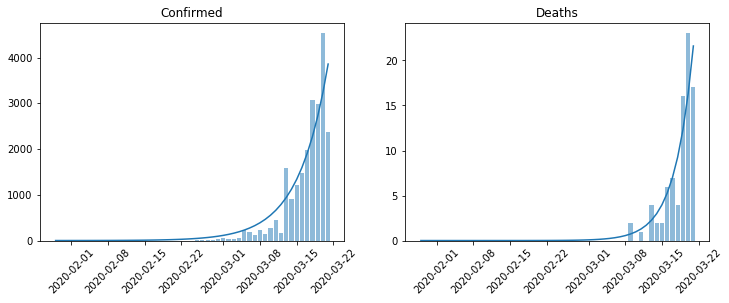

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for ax, field in zip(axs, fields):
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]
    ax.bar(df["date"][1:], y, alpha=0.5)
    ax.plot(df["date"][1:], func(x, *popt))
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)

Plot both new and cumulative

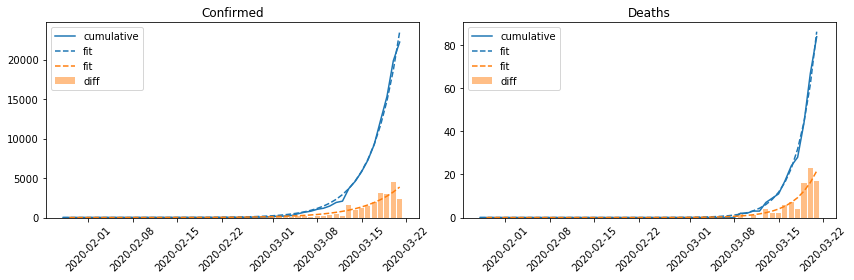

In [13]:
fig, axs = plt.subplots(ncols=len(fields), figsize=(12, 4))

for ax, field in zip(axs, fields):
    
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]
    popt_int, pcov_int = fit_results_int[field]

    ax.plot(df["date"], y_int, label="cumulative", color="C0")
    ax.plot(df["date"], func(x_int, *popt_int), "--", label="fit", color="C0")

    ax.bar(df["date"][1:], y, label="diff", color="C1", alpha=0.5)
    ax.plot(df["date"][1:], func(x, *popt), "--", label="fit", color="C1")

    ax.xaxis.set_tick_params(rotation=45)
    ax.legend()

    #ax.set_yscale("log")
    #ax.set_ylim(bottom=1e-1)
    ax.set_ylim(auto=True)
    ax.set_yscale("linear")
    
    ax.set_title(field)
fig.tight_layout()

<ipython-input-14-ae0cf8ca092b>:10: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(df["date"][1:], y / y_int[:-1])
<ipython-input-14-ae0cf8ca092b>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(df["date"][1:], y / y_int[:-1])


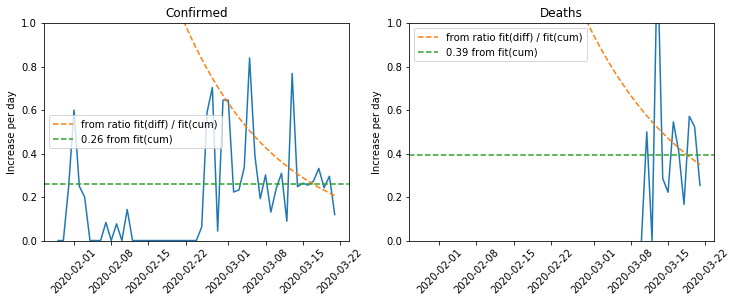

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for ax, field in zip(axs, fields):

    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]

    inc_from_param = np.exp(popt_int[1]) - 1
    ax.plot(df["date"][1:], y / y_int[:-1])
    ax.plot(
        df["date"][1:],
        func(x, *popt) / func(x_int, *popt_int)[:-1],
        color="C1",
        linestyle="--",
        label="from ratio fit(diff) / fit(cum)"
    )
    ax.axhline(inc_from_param, linestyle="--", color="C2", label=f"{inc_from_param:.2f} from fit(cum)")
    ax.set_ylabel("Increase per day")
    ax.xaxis.set_tick_params(rotation=45)
    ax.legend()
    ax.set_title(field)
    ax.set_ylim(0, 1)

### Extrapolation of cumulative cases

Extrapolated until 2020-03-30 00:00:00
Confirmed: 190418.83973157615
Deaths: 1719.558574493834


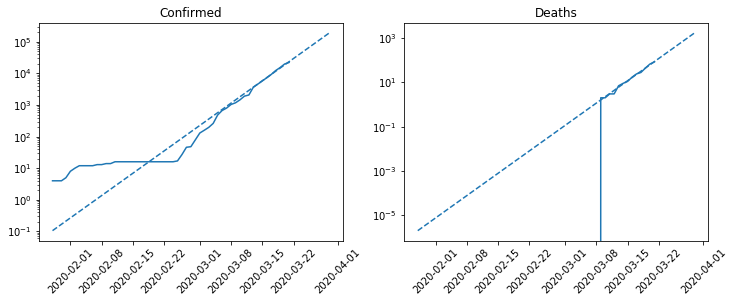

In [15]:
dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-03-30", freq="d")
days = np.arange(len(dates_extrap))

fig, axs = plt.subplots(ncols=len(fields), figsize=(12, 4))

print(f"Extrapolated until {dates_extrap[-1]}")

for ax, field in zip(axs, fields):
    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    pred = func(days, *popt_int)
    ax.plot(df["date"], y_int, label="confirmed", color="C0")
    ax.plot(dates_extrap, pred, "--", color="C0")
    ax.set_yscale("log")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)
    print(f"{field}: {pred[-1]}") # predicted by end of range

### Fitted Parameters and doubling time

In [16]:
fit_results_int

{'Confirmed': (array([0.28777045, 0.23232961, 4.3122464 ]),
  array([[2.04302817e+09, 1.56956649e+01, 3.05579098e+10],
         [1.56956639e+01, 1.47251178e-05, 2.34765592e+02],
         [3.05579098e+10, 2.34765606e+02, 4.57059704e+11]])),
 'Deaths': (array([2.54000698e-06, 3.32386812e-01, 8.26794943e-01]),
  array([[2.16844509e-01, 4.97850275e-04, 2.56844421e+05],
         [4.97850052e-04, 3.30488085e-05, 5.89690154e+02],
         [2.56844421e+05, 5.89690419e+02, 3.04222859e+11]]))}

In [17]:
fit_results_diff

{'Confirmed': (array([0.50832561, 0.17652312, 2.38459391]),
  array([[1.83891575e+11, 2.64226960e+03, 2.05777702e+12],
         [2.64226932e+03, 3.33693832e-04, 2.95675097e+04],
         [2.05777702e+12, 2.95675129e+04, 2.30268637e+13]])),
 'Deaths': (array([8.74669861e-06, 2.82562311e-01, 9.05540827e-01]),
  array([[3.46944196e+00, 6.96867765e-03, 1.40378816e+06],
         [6.96867765e-03, 7.56263558e-04, 2.81976469e+03],
         [1.40378816e+06, 2.81976469e+03, 5.67993704e+11]]))}

In [18]:
np.log(2) / fit_results_int["Confirmed"][0][1]

2.98346461202498

In [19]:
np.log(2) / fit_results_int["Deaths"][0][1]

2.085363062044017

### Death rate

In [20]:
df["death_rate"] = df["Deaths"] / df["Confirmed"]

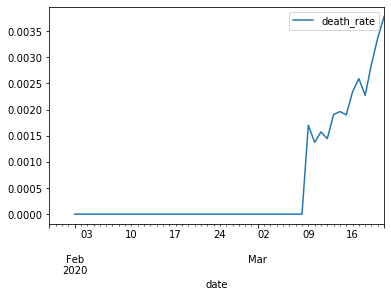

In [21]:
df.plot(x="date", y="death_rate")